In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
import random
np.random.seed(0) 

In [4]:
# Toy Example Settings 
dim = 1000
alph = 1e-4 #Alpha of ridge regression, how severe the penalty is
NFuncSamples = 30000 #Number of sample coefficients to draw and use for prediction
vis = 0.5 #Transparency of plotted lines - in case we wish to plot a bunch.
train_size = 10000
test_size = 500
sigma2 = 49
interp_num = 30

In [5]:
# Function 1: generate xtrain, xtest data
# method: use multivariate normal
def generate_data(dim, train_size, test_size, sigma2):
    xtrain = np.random.normal(0, 3, (train_size, dim))
    xtest = np.random.normal(20, 3, (test_size, dim))
    ytrain = 7 + 3*xtrain.mean(axis=1) + np.random.normal(size=train_size)*np.sqrt(sigma2)
    ytest = 7 + 3*xtest.mean(axis=1) + np.random.normal(size=xtest.shape[0])*np.sqrt(sigma2)
    return xtrain,xtest,ytrain,ytest

In [6]:
# Function 2: interpolate training and test data, do PCA
def interp_PC(dim, xtrain, xtest, interp_num):
    arr1 = np.array([np.linspace(xtrain[0][i], xtest[0][i], num=interp_num) for i in range(dim)])
    arr2 = arr1.swapaxes(0,1)
    xall = np.row_stack([xtrain, xtest, arr2])
    pca = PCA(n_components=1)
    pca.fit(xall)
    xtrain_PCs = pca.transform(xtrain)
    xtest_PCs = pca.transform(xtest)
    xall_PCs = pca.transform(xall)
    return arr2, xall, xtrain_PCs, xtest_PCs, xall_PCs

In [7]:
# Function 3: train the model and output predictive distribution for every data points
def train(xtrain, ytrain, xall, alph, dim, sigma2):
    LinR = Ridge(alpha=alph, fit_intercept=True) #linear least square, alpha->regularization
    LinR.fit(xtrain, ytrain) # fit model
    
    ypredmle = LinR.predict(xtest) #MLE prediction
    noisemle = np.var(ytrain - LinR.predict(xtrain),ddof=1) #MLE noise estimation
    
    wmle = LinR.coef_.reshape(-1,) #Mean of coefficients
    wcov = sigma2 * np.linalg.inv(np.diag([alph]*dim) + xtrain.T.dot(xtrain)) #Covariance of coefficients
    postnoise = np.array([np.sqrt(sigma2 + xall[i,:].T.dot(wcov.dot(xall[i,:]))) for i in range(xall.shape[0])])
    return ypredmle, noisemle, wmle, wcov, postnoise

In [8]:
xtrain, xtest, ytrain, ytest = generate_data(dim, train_size, test_size, sigma2)
interp_x, xall, xtrain_PCs, xtest_PCs, xall_PCs = interp_PC(dim, xtrain, xtest, interp_num)

In [16]:
xall.shape

(10530, 1000)

In [17]:
# 4 Plots of Evaluation

Text(0, 0.5, 'x2')

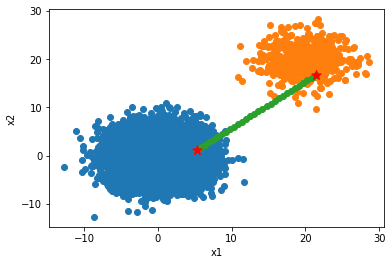

In [18]:
# Plot1: scatter plot of training and testing data
plt.scatter(xtrain[:, 0], xtrain[:, 1])
plt.scatter(xtest[:, 0], xtest[:, 1])
plt.scatter(interp_x[:, 0], interp_x[:, 1])
plt.scatter(xtrain[0][0], xtrain[0][1], marker='*', color='red', s=100)
plt.scatter(xtest[0][0], xtest[0][1], marker='*', color='red', s=100)
plt.xlabel("x1")
plt.ylabel("x2")

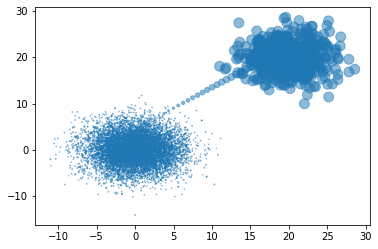

In [19]:
# Plot2: scatter plot of all datapoints with predictive distribution
ypredmle, noisemle, wmle, wcov, postnoise = train(xtrain, ytrain, xall, alph, dim, sigma2)
plt.scatter(xall[:, 99], xall[:, 100], s=100 * (postnoise - postnoise.min()) / (postnoise.max() - postnoise.min()), alpha=0.5)

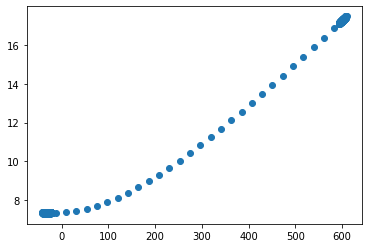

In [23]:
# Plot3: scatter plot of PC1 and predictive noise
plt.scatter(xall_PCs[:, 0], postnoise)

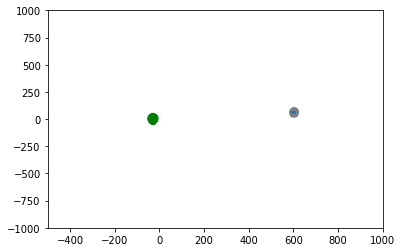

In [21]:
# Plot4: 
fig, ax = plt.subplots()
ax.scatter(xtest_PCs[:,0], ytest, s=20, color='grey', label='training data')
ax.scatter(xtrain_PCs[:,0], ytrain, s=20, color='g', label='training data')
plt.ylim([-1000,1000])    
plt.xlim([-500,1000])
lowerb = postnoise
upperb = postnoise
Errlogi = lowerb is not None or upperb is not None # Determines where we will be plotting error bars as well
if Errlogi: 
    errspacing = [int(round(s)) for s in np.linspace(0,xtest_PCs.shape[0]-1,20)] # where to plot the error bars
    ax.errorbar(xtest_PCs[errspacing], ypredmle[errspacing], yerr=[lowerb[errspacing],upperb[errspacing]]) # why yerr a tuple of 2 same things?